In [2]:
# 为这个项目导入需要的库
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # 允许为DataFrame使用display()

# 导入附加的可视化代码visuals.py
import visuals as vs

# 魔法函数，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步
%matplotlib inline

# 导入人口普查数据
data = pd.read_csv("census.csv")

# 成功 - 显示第一条记录
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [7]:
data.shape

(45222, 14)

In [8]:
n_records = data.shape[0]

from pandas import Series
n_greater_50k = pd.value_counts(data.income == ">50K")[True]
n_at_most_50k = pd.value_counts(data.income == "<=50K")[True]

greater_percent = n_greater_50k/n_records*100

# 打印结果
print ("Total number of records: {}".format(n_records))
print ("Individuals making more than $50,000: {}".format(n_greater_50k))
print ("Individuals making at most $50,000: {}".format(n_at_most_50k))
print ("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


In [9]:
# 将数据切分成特征和对应的标签
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

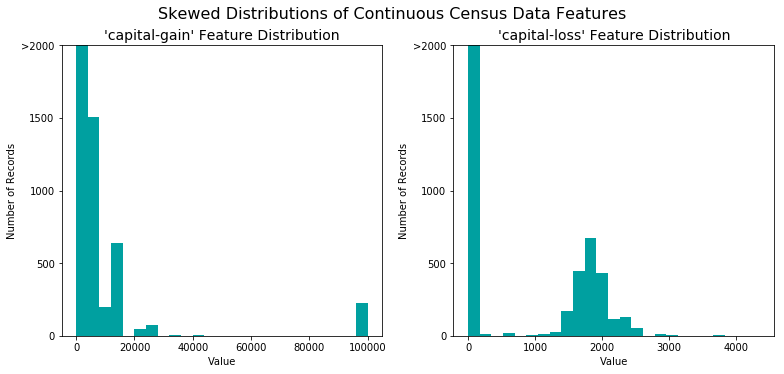

In [10]:
# 可视化 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw)

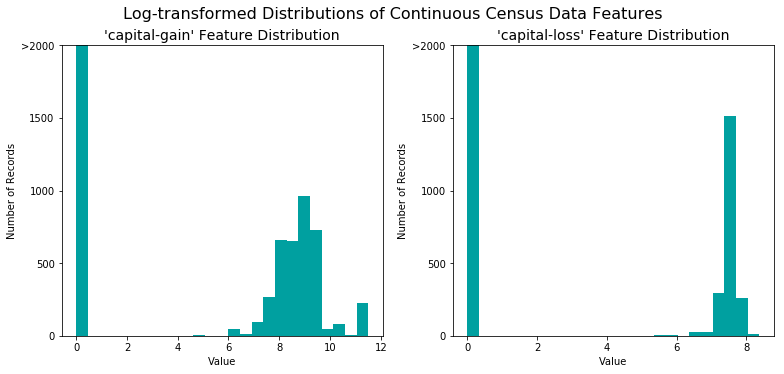

In [11]:
# 对于倾斜的数据使用Log转换
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# 可视化对数转换后 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw, transformed = True)

In [12]:
from sklearn.preprocessing import MinMaxScaler

# 初始化一个 scaler，并将它施加到特征上
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# 显示一个经过缩放的样例记录
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


In [13]:
#进行独热编码
features = pd.get_dummies(features_raw)
income = income_raw.map({'<=50K':0, '>50K':1})

# 打印经过独热编码之后的特征数量
encoded = list(features.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

In [14]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'features'和'income'数据切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0,
                                                    stratify = income)
# 将'X_train'和'y_train'进一步切分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0,
                                                    stratify = y_train)

# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 28941 samples.
Validation set has 7236 samples.
Testing set has 9045 samples.


In [15]:
accuracy = n_greater_50k/n_records
precision = n_greater_50k/n_records
recall = n_greater_50k/n_greater_50k

beta = 0.5
fscore = (1 + pow(beta, 2))*(precision*recall)/((pow(beta, 2)*precision) + recall)

# 打印结果
print ("Naive Predictor on validation data: \n \
    Accuracy score: {:.4f} \n \
    Precision: {:.4f} \n \
    Recall: {:.4f} \n \
    F-score: {:.4f}".format(accuracy, precision, recall, fscore))

Naive Predictor on validation data: 
     Accuracy score: 0.2478 
     Precision: 0.2478 
     Recall: 1.0000 
     F-score: 0.2917


In [19]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_val: features validation set
       - y_val: income validation set
    '''
    
    results = {}
    
    start = time() # 获得程序开始时间
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # 获得程序结束时间
    
    results['train_time'] = end - start
    
    # 然后得到对前300个训练数据的预测结果
    start = time() # 获得程序开始时间
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train[:300])
    end = time() # 获得程序结束时间
    
    # 计算预测用时
    results['pred_time'] = end - start
            
    # 计算在最前面的300个训练数据的准确率
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # 计算在验证上的准确率
    results['acc_val'] = accuracy_score(y_val,predictions_val)
    
    # 计算在最前面300个训练数据上的F-score
    results['f_train'] = fbeta_score(y_train[: 300], predictions_train, beta=0.5)
        
    # 计算验证集上的F-score
    results['f_val'] = fbeta_score(y_val, predictions_val, beta=0.5)
       
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # 返回结果
    return results

[289, 2894, 28941]
DecisionTreeClassifier trained on 289 samples.
DecisionTreeClassifier trained on 2894 samples.
DecisionTreeClassifier trained on 28941 samples.
SVC trained on 289 samples.


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 2894 samples.
SVC trained on 28941 samples.
AdaBoostClassifier trained on 289 samples.
AdaBoostClassifier trained on 2894 samples.
AdaBoostClassifier trained on 28941 samples.


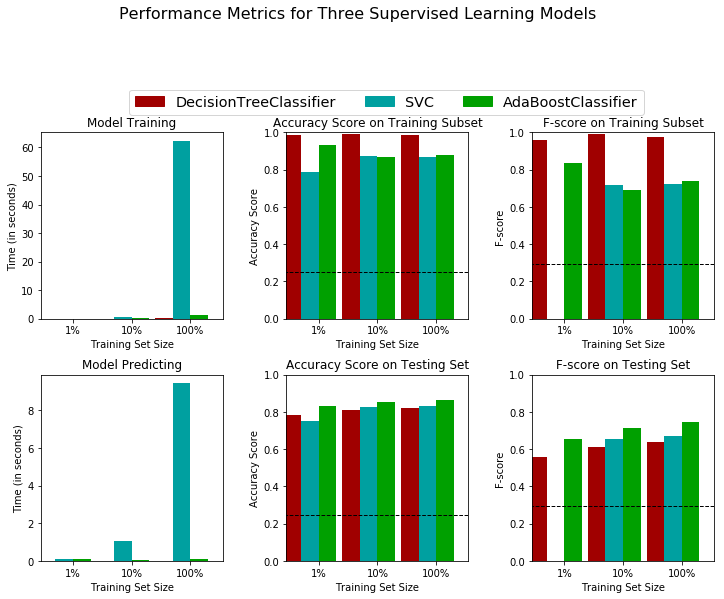

In [20]:
# 从sklearn中导入三个监督学习模型
from sklearn import tree, svm, ensemble

# 初始化三个模型
clf_A = tree.DecisionTreeClassifier(random_state = 0)
clf_B = svm.SVC(random_state = 0)
clf_C = ensemble.AdaBoostClassifier(random_state = 0)

# 计算1%， 10%， 100%的训练数据分别对应多少点
samples_1 = int(X_train.shape[0]*0.01)
samples_10 = int(X_train.shape[0]*0.1)
samples_100 = int(X_train.shape[0] * 1)
print ([samples_1, samples_10, samples_100])

# 收集学习器的结果
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_val, y_val)

# 对选择的三个模型得到的评价结果进行可视化
vs.evaluate(results, accuracy, fscore)

In [ ]:
# 导入'GridSearchCV', 'make_scorer'和其他一些需要的库
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier

# 初始化分类器
clf = AdaBoostClassifier(random_state=0)

# 创建你希望调节的参数列表
parameters = {'n_estimators': [50, 100, 200, 300]}

# 创建一个fbeta_score打分对象
scorer = make_scorer(fbeta_score, beta=0.5)

# 在分类器上使用网格搜索，使用'scorer'作为评价函数
kfold = KFold(n_splits=10)
grid_obj = GridSearchCV(clf, parameters, scorer, cv=kfold)

# 用训练数据拟合网格搜索对象并找到最佳参数
grid_fit = grid_obj.fit(X_train, y_train)

# 得到estimator
best_clf = grid_obj.best_estimator_

# 使用没有调优的模型做预测
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions = best_clf.predict(X_val)

# 汇报调优后的模型
print ("best_clf\n------")
print (best_clf)

# 汇报调参前和调参后的分数
print ("\nUnoptimized model\n------")
print ("Accuracy score on validation data: {:.4f}".format(accuracy_score(y_val, predictions)))
print ("F-score on validation data: {:.4f}".format(fbeta_score(y_val, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
print ("Final F-score on the validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5)))

In [ ]:
# 导入一个有'feature_importances_'的监督学习模型
from sklearn.ensemble import RandomForestClassifier

# 在训练集上训练一个监督学习模型
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# 提取特征重要性
importances = model.feature_importances_
#importances_AdaBoost = best_clf.feature_importances_

# 绘图
vs.feature_plot(importances, X_train, y_train)
#vs.feature_plot(importances_AdaBoost, X_train, y_train)

In [ ]:
# 导入克隆模型的功能
from sklearn.base import clone

# 减小特征空间
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_val_reduced = X_val[X_val.columns.values[(np.argsort(importances)[::-1])[:5]]]

# 在前面的网格搜索的基础上训练一个“最好的”模型
clf_on_reduced = (clone(best_clf)).fit(X_train_reduced, y_train)

# 做一个新的预测
reduced_predictions = clf_on_reduced.predict(X_val_reduced)

# 对于每一个版本的数据汇报最终模型的分数
print ("Final Model trained on full data\n------")
print ("Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
print ("F-score on validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5)))
print ("\nFinal Model trained on reduced data\n------")
print ("Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, reduced_predictions)))
print ("F-score on validation data: {:.4f}".format(fbeta_score(y_val, reduced_predictions, beta = 0.5)))

In [ ]:
predictions_test = best_clf.predict(X_test)
print ("Accuracy on best_clf is {:.4f}" .format(accuracy_score(y_test, predictions_test)))
print ("F-Score on best_clf is {:.4f}" .format(fbeta_score(y_test, predictions_test, beta=0.5)))